In [2]:
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from node2vec import Node2Vec
import os
import pickle

d:\DS\ml-pueblos\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load the dataset from backoffice
df_pueblos = pd.read_csv("../../data/end_product_data/pueblos_recommender.csv")

pueblos_cmun = df_pueblos['cmun'].tolist()

# Load the dataset from user chosen villages
user_files = os.listdir("../../data/user_output/")

user_choices = []

# Get all files from the user_output directory

# Read each file into a DataFrame and add to the list
for file in user_files:
    file_path = os.path.join("../../data/user_output/", file)
    user_df = pd.read_csv(file_path)
    user_choices.append(user_df)

# user choices of first user
user_choices_cmun = user_choices[0].cmun.tolist()
# display(pueblos_cmun)
# display(user_choices_cmun)
df_pueblos.shape

(6824, 64)

In [4]:
df_pueblos_enc = df_pueblos.filter(regex=r"^enc_", axis=1)
# Select only numerical features with more than 2 unique values (non-binary features)
pueblos_numerical_features = df_pueblos_enc.loc[:, (df_pueblos_enc.nunique() > 2)]

# Process user choices: filter for encoded features and remove binary columns
processed_user_choices = []
for df in user_choices:
    df_filtered = df.filter(regex=r"^enc_", axis=1)
    df_non_binary = df_filtered.loc[:, ~(df_filtered.isin([0.0, 1.0]).all())]
    processed_user_choices.append(df_non_binary)
# 
display(processed_user_choices[0])
display(pueblos_numerical_features)


,enc_scaled__total_population,enc_scaled__score_age,enc_scaled__score_transport,enc_scaled__score_school_distance,enc_scaled__score_area_school,enc_scaled__score_area_hospital,enc_scaled__score_hospital_distance,enc_scaled__score_area_economy,enc_scaled__score_economy,enc_scaled__score_connectivity
0,3.368308,1.304826,-1.030632,0.719746,0.719746,1.817426,1.817426,6.543412,6.543412,0.548894
1,-0.658619,-0.873514,-1.067377,-0.265322,-0.265322,0.268855,0.268855,-0.400296,-0.400296,1.035708
2,3.502093,1.537814,-1.415148,0.719746,0.719746,2.591711,2.591711,4.507509,4.507509,1.123627
3,-0.687737,0.518934,-0.540559,-1.250390,-1.250390,-0.892572,-0.892572,-0.400296,-0.400296,-0.004673
4,3.547738,1.171504,-0.462186,0.719746,0.719746,0.268855,0.268855,3.760027,3.760027,0.853356


,enc_scaled__total_population,enc_scaled__score_age,enc_scaled__score_transport,enc_scaled__score_school_distance,enc_scaled__score_area_school,enc_scaled__score_area_hospital,enc_scaled__score_hospital_distance,enc_scaled__score_area_economy,enc_scaled__score_economy,enc_scaled__score_connectivity
0,3.557181,-0.473490,5.792635,0.719746,0.719746,-0.892572,-0.892572,4.173109,4.173109,-0.613597
1,1.865195,0.672636,2.815405,0.719746,0.719746,1.043140,1.043140,0.416032,0.416032,0.820793
2,2.560877,0.136504,2.739097,0.719746,0.719746,1.817426,1.817426,0.652079,0.652079,0.544010
3,0.059098,-0.410759,3.798159,0.719746,0.719746,-0.118287,-0.118287,0.071797,0.071797,-1.261597
4,2.080038,-0.029549,2.550249,0.719746,0.719746,0.268855,0.268855,1.271701,1.271701,0.778462
...,...,...,...,...,...,...,...,...,...,...
6819,3.610695,1.572655,0.327924,0.719746,0.719746,-0.505430,-0.505430,1.950336,1.950336,1.024311
6820,0.522624,0.596693,-1.010917,0.719746,0.719746,0.268855,0.268855,0.337350,0.337350,0.571688
6821,3.386409,1.345018,-0.159224,0.719746,0.719746,-0.892572,-0.892572,2.294571,2.294571,0.545638
6822,1.622808,1.366077,-0.842902,0.719746,0.719746,1.817426,1.817426,0.337350,0.337350,1.079668


In [ ]:
import networkx as nx
# 1️⃣ Construct the Graph
G = nx.Graph()
for i, row in pueblos_numerical_features.iterrows():
    # get cmun of row
    cmun = df_pueblos.iloc[i, 0]
    G.add_node(cmun, **row.to_dict())

# Compute pairwise feature similarity (Cosine Similarity)
feature_matrix = pueblos_numerical_features
similarity_matrix = cosine_similarity(feature_matrix)



NodeView((15061, 27025, 27013, 15025, 33070, 27063, 15076, 33021, 33023, 27038, 15049, 33039, 15081, 27005, 33069, 27002, 33017, 33018, 15055, 33030, 33019, 39047, 39006, 27027, 39011, 27033, 33074, 33056, 15051, 39005, 39043, 39061, 33013, 27061, 33077, 33010, 39029, 33007, 27030, 48012, 39044, 39009, 33009, 15015, 39040, 33054, 48056, 33065, 33059, 33063, 39062, 48068, 48014, 48077, 48031, 39031, 33042, 48076, 39036, 48048, 39076, 39080, 39024, 48021, 48061, 39068, 48028, 39028, 39084, 48089, 39095, 39099, 33055, 33045, 39038, 39001, 27001, 48064, 48040, 48049, 33071, 27054, 33040, 48033, 39102, 27021, 48908, 39030, 48053, 48041, 39048, 27048, 48913, 48063, 15091, 39002, 39037, 48010, 39064, 39090, 48907, 33043, 48906, 48047, 33029, 33006, 39091, 48035, 48004, 15050, 15043, 39018, 48909, 33046, 48079, 48018, 39019, 48903, 48038, 48914, 33075, 33047, 39033, 33057, 20056, 39058, 20039, 48911, 27044, 48904, 33008, 33064, 39056, 39041, 48066, 48070, 20029, 48067, 15064, 15039, 48062, 489

## Cosine Based Graph

### Calculate graph density (ratio of actual edges to potential edges in a complete graph)
 Graph density ranges from 0 (no connections) to 1 (fully connected)
- Very low density (<0.01): Too sparse, might have isolated nodes and poor recommendations
- Low density (0.01-0.05): Sparse but workable for large graphs
- Medium density (0.05-0.2): Good balance for recommendation systems
- High density (>0.2): May be too connected, less discriminative recommendations
 
If density is too high: Increase similarity threshold
If density is too low: Decrease similarity threshold or use KNN approach

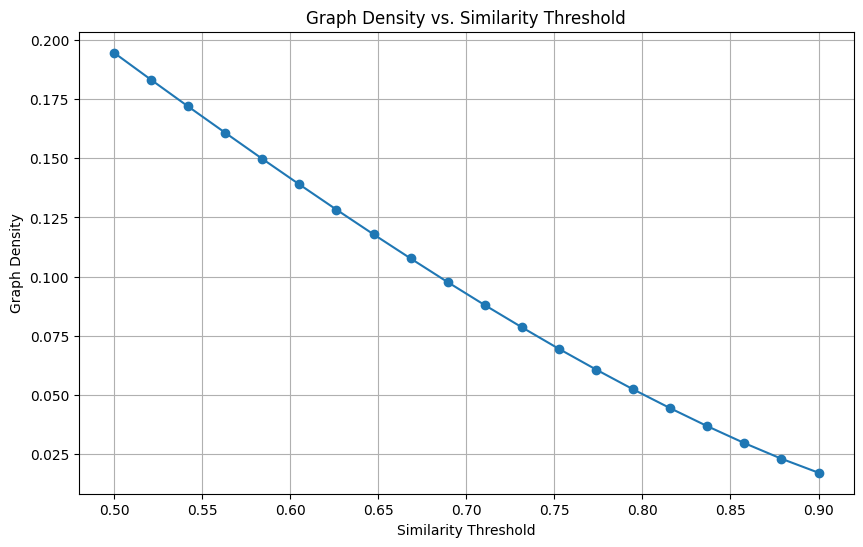

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Load the dataset from backoffice
df_pueblos = pd.read_csv("../../data/end_product_data/pueblos_recommender.csv")
pueblos_cmun = df_pueblos['cmun'].tolist()

# Filter for numerical features
df_pueblos_enc = df_pueblos.filter(regex=r"^enc_", axis=1)
pueblos_numerical_features = df_pueblos_enc.loc[:, (df_pueblos_enc.nunique() > 2)]

# Compute pairwise feature similarity (Cosine Similarity)
feature_matrix = pueblos_numerical_features
similarity_matrix = cosine_similarity(feature_matrix)

# Function to compute graph density for a given threshold
def compute_graph_density(threshold):
    G = nx.Graph()
    for i in range(len(feature_matrix)):
        village_i = pueblos_cmun[i]
        for j in range(i + 1, len(feature_matrix)):
            if similarity_matrix[i, j] > threshold:
                village_j = pueblos_cmun[j]
                G.add_edge(village_i, village_j, weight=similarity_matrix[i, j])
    return nx.density(G)

# Range of thresholds to test
thresholds = np.linspace(0.5, 0.9, 20)
densities = [compute_graph_density(threshold) for threshold in thresholds]

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(thresholds, densities, marker='o')
plt.title('Graph Density vs. Similarity Threshold')
plt.xlabel('Similarity Threshold')
plt.ylabel('Graph Density')
plt.grid(True)
plt.show()

In [ ]:
# Add edges based on similarity threshold
threshold = 0.72  # Adjust threshold based on data distribution

# Use batching for edge creation to avoid memory issues
batch_size = 2000
for i in range(len(feature_matrix)):
    village_i = pueblos_cmun[i]
    for j in range(i + 1, min(i + batch_size, len(feature_matrix))):
        if similarity_matrix[i, j] > threshold:
            village_j = pueblos_cmun[j]
            G.add_edge(village_i, village_j, weight=similarity_matrix[i, j])

            
density = nx.density(G)
print(f"Graph Density: {density:.4f}")

# Calculate graph density to assess connectivity
density = nx.density(G)
print(f"Graph Density: {density:.4f}")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Check for isolated nodes
isolated = list(nx.isolates(G))
print(f"Number of isolated nodes: {len(isolated)}")

Graph Density: 0.0794
Graph Density: 0.0794
Number of nodes: 6821
Number of edges: 1846470
Number of isolated nodes: 0


In [ ]:
# # Add edges based on similarity threshold
# threshold = 0.78  # Lower threshold to create more connections

# # Use village IDs (cmun) instead of indices for the graph
# for i in range(len(pueblos_cmun)):
#     village_i = pueblos_cmun[i]
#     # Connect to top 10 most similar villages to ensure minimum connectivity
#     similar_indices = np.argsort(similarity_matrix[i])[::-1][1:11]
#     for j in similar_indices:
#         village_j = pueblos_cmun[j]
#         G.add_edge(village_i, village_j, weight=similarity_matrix[i, j])
    
#     # Add extra connections if similarity is above threshold
#     for j in range(len(pueblos_cmun)):
#         if j not in similar_indices and i != j and similarity_matrix[i, j] > threshold:
#             village_j = pueblos_cmun[j]
#             G.add_edge(village_i, village_j, weight=similarity_matrix[i, j])

# # Calculate graph density to assess connectivity
# density = nx.density(G)
# print(f"Graph Density: {density:.4f}")
# print(f"Number of nodes: {G.number_of_nodes()}")
# print(f"Number of edges: {G.number_of_edges()}")

# # Check for isolated nodes
# isolated = list(nx.isolates(G))
# print(f"Number of isolated nodes: {len(isolated)}")


Graph Density: 0.0824
Number of nodes: 6821
Number of edges: 1916291
Number of isolated nodes: 0


## KNN Based Graph

In [ ]:
# # Use k-Nearest Neighbors to create edges
# k = 50  # Each village connects to its 50 most similar villages
# for i in range(len(similarity_matrix)):
#     # Get indices of top k similar villages (excluding self)
#     similar_indices = np.argsort(similarity_matrix[i])[::-1][1:k+1]
    
#     # Create edges to the most similar villages
#     for j in similar_indices:
#         G.add_edge(pueblos_cmun[i], pueblos_cmun[j], weight=similarity_matrix[i, j])

# density = nx.density(G)
# print(f"Graph Density: {density:.4f}")

Graph Density: 0.0076


In [ ]:
# 2️⃣ Generate Node2Vec Embeddings
node2vec = Node2Vec(G, dimensions=16, walk_length=15, num_walks=50, workers=6)

Computing transition probabilities:   3%|▎         | 204/6821 [00:15<09:40, 11.39it/s]

In [ ]:
model = node2vec.fit(
    window=5,    
    min_count=1, 
    batch_words=50,  
    epochs=5,    
    sg=0,            
    hs=0,          
    negative=7        
)

In [ ]:
display(similarity_matrix)

array([[ 1.        ,  0.723396  ,  0.69736333, ...,  0.72957946,
         0.16038188, -0.06239642],
       [ 0.723396  ,  1.        ,  0.96367783, ...,  0.52713098,
         0.58274212, -0.31754954],
       [ 0.69736333,  0.96367783,  1.        , ...,  0.54329762,
         0.67090616, -0.37992173],
       ...,
       [ 0.72957946,  0.52713098,  0.54329762, ...,  1.        ,
         0.51065835, -0.36601523],
       [ 0.16038188,  0.58274212,  0.67090616, ...,  0.51065835,
         1.        , -0.72235604],
       [-0.06239642, -0.31754954, -0.37992173, ..., -0.36601523,
        -0.72235604,  1.        ]])

In [ ]:
# Create models directory if it doesn't exist
os.makedirs('../../models', exist_ok=True)

# Save the Node2Vec embeddings
model_path = '../../models/node2vec.model'
model.save(model_path)

print(f"Model saved to {model_path}")

# If you want to save the graph separately
graph_path = '../../models/village_graph.pkl'
with open(graph_path, 'wb') as f:
    pickle.dump(G, f)
    
print(f"Graph saved to {graph_path}")

Model saved to ../../models/node2vec.model
Graph saved to ../../models/village_graph.pkl


## Why Do We Use node2vec If We Just Use Cosine Similarity Later?

Good question! Here’s why:

✅ node2vec learns embeddings that capture graph structure (community, structural similarities, etc.).
✅ These embeddings are better than raw features for similarity because they encode relationships beyond direct numerical similarity.
✅ Cosine similarity works on embeddings (not raw data), meaning it measures similarity in a meaningful latent space.

So, node2vec transforms the problem:

Instead of comparing raw village features, we compare graph-informed village embeddings using cosine similarity.

In [ ]:
# 3️⃣ Compute Similarity
user_selected_villages = user_choices_cmun # Example selected villages

selected_vectors = [model.wv[str(v)] for v in user_selected_villages]
centroid_vector = np.mean(selected_vectors, axis=0)

# Rank all villages based on cosine similarity
all_village_vectors = {v: model.wv[str(v)] for v in G.nodes()}
similarities = {v: cosine_similarity([centroid_vector], [vec])[0][0] for v, vec in all_village_vectors.items()}
ranked_villages = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

# 4️⃣ Evaluate Ranking Quality
def ndcg_at_k(ranked_list, ideal_list, k):
    def dcg(scores):
        return sum([(2**s - 1) / np.log2(i+2) for i, s in enumerate(scores)])
    
    ideal_scores = [1 if v in ideal_list else 0 for v, _ in ranked_list[:k]]
    return dcg(ideal_scores) / dcg(sorted(ideal_scores, reverse=True))

ndcg_score = ndcg_at_k(ranked_villages, user_selected_villages, k=10)
print(f"NDCG Score: {ndcg_score:.4f}")

# Display top similar villages
print("Top 10 Most Similar Villages:")
for village, score in ranked_villages[:10]:
    print(f"Village {village}: Similarity {score:.4f}")

NDCG Score: 1.0000
Top 10 Most Similar Villages:
Village 2024: Similarity 0.9998
Village 2234: Similarity 0.9972
Village 1837: Similarity 0.9958
Village 2279: Similarity 0.9890
Village 2333: Similarity 0.9845
Village 2034: Similarity 0.9826
Village 1514: Similarity 0.9811
Village 1833: Similarity 0.9800
Village 1992: Similarity 0.9782
Village 1896: Similarity 0.9658


12928

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Extract top 10 similar villages and their scores
# top_villages = ranked_villages[:10]
# village_ids = [v for v, _ in top_villages]
# similarity_scores = [s for _, s in top_villages]

# # Create a bar plot
# plt.figure(figsize=(12, 6))
# sns.barplot(x=village_ids, y=similarity_scores, palette="viridis")
# plt.xlabel("Village ID")
# plt.ylabel("Cosine Similarity")
# plt.title("Top 10 Most Similar Villages to User Profile Centroid")
# plt.xticks(rotation=45)
# plt.show()

In [ ]:
# # 5. Display top similar villages
# print("Top 10 Most Similar Villages:")
# for village, score in ranked_villages_svd[:10]:
#     print(f"Village {village}: Similarity {score:.4f}")

# # 6. Visualize top similarities with a bar chart
# top_n = 10
# village_ids = [str(v) for v, _ in ranked_villages_svd[:top_n]]
# similarity_scores = [score for _, score in ranked_villages_svd[:top_n]]

# plt.figure(figsize=(12, 6))
# sns.barplot(x=village_ids, y=similarity_scores, hue=village_ids, palette="viridis", legend=False)
# plt.title('Top Similar Villages')
# plt.xlabel('Village ID')
# plt.ylabel('Cosine Similarity')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [ ]:
# # 6. Visualize top similarities with a bar chart
# top_n = 10
# village_ids = [str(v) for v, _ in ranked_villages_svd[:top_n]]
# similarity_scores = [score for _, score in ranked_villages_svd[:top_n]]

# plt.figure(figsize=(12, 6))
# sns.barplot(x=village_ids, y=similarity_scores, hue=village_ids, palette="viridis", legend=False)
# plt.title('Top Similar Villages')
# plt.xlabel('Village ID')
# plt.ylabel('Cosine Similarity')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

## TSVD dimensionality reduction on all centroids

In [ ]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=5)

In [ ]:
from gensim.models import Word2Vec

# Load the Node2Vec embeddings
model_path = '../../models/node2vec.model'
model = Word2Vec.load(model_path)

print(f"Model loaded from {model_path}")

# Load the graph from pickle
graph_path = '../../models/village_graph.pkl'
with open(graph_path, 'rb') as f:
    G = pickle.load(f)
    
print(f"Graph saved to {graph_path}")

Model loaded from ../../models/node2vec.model
Graph saved to ../../models/village_graph.pkl


In [ ]:
# Ensure all CMUNs in the graph are in the DataFrame
graph_cmun_set = set(G.nodes())
df_cmun_set = set(df_pueblos['cmun'])

missing_in_df = graph_cmun_set - df_cmun_set
missing_in_graph = df_cmun_set - graph_cmun_set

print(f"CMUNs in graph but not in DataFrame: {missing_in_df}")
print(f"CMUNs in DataFrame but not in graph: {missing_in_graph}")

# Remove nodes from the graph that are not in the DataFrame
for cmun in missing_in_df:
    G.remove_node(cmun)

# Optionally, add nodes to the graph that are in the DataFrame but not in the graph
for cmun in missing_in_graph:
    G.add_node(cmun, **df_pueblos[df_pueblos['cmun'] == cmun].to_dict('records')[0])

CMUNs in graph but not in DataFrame: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 21

In [ ]:
# 2. Get all village vectors (handling missing nodes)
all_village_vectors = {}
for v in G.nodes():
    try:
        all_village_vectors[v] = model.wv[str(v)]
    except KeyError:
        print(f"Warning: Village {v} not found in model")
        continue

# 3. Apply TruncatedSVD to reduce dimensionality
all_vectors = np.array(list(all_village_vectors.values()))
pueblos_latent_features = svd.fit_transform(all_vectors)

In [ ]:

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Get vectors for user-selected villages
user_selected_villages = user_choices_cmun
valid_villages = []
selected_vectors = []

for v in user_selected_villages:
    try:
        vector = model.wv[str(v)]
        selected_vectors.append(vector)
        valid_villages.append(v)
    except KeyError:
        print(f"Warning: Village {v} not found in model")

display(selected_vectors)
user_latent_features = svd.transform(np.array(selected_vectors))



[array([-0.05691848, -0.0202939 , -0.01524804,  0.01266737, -0.02609479,
        -0.04652832, -0.03966154,  0.01080409,  0.03907142, -0.01994681,
        -0.04487358,  0.0396278 ,  0.02898764,  0.03087335,  0.01522205,
         0.00908893], dtype=float32),
 array([-0.02984623, -0.0225807 , -0.01991094, -0.00748251,  0.01734564,
         0.00184932,  0.00434436,  0.04332954,  0.00081485, -0.03452463,
         0.03413352, -0.05123151,  0.02901682,  0.01149558, -0.0120282 ,
        -0.01454762], dtype=float32),
 array([-0.04628117, -0.0381148 ,  0.05936839, -0.00986677, -0.01198152,
        -0.03196444,  0.01528578,  0.0521592 ,  0.03188216, -0.00780251,
        -0.01148304, -0.01837798, -0.00925867,  0.05168692, -0.04429523,
         0.04351309], dtype=float32),
 array([-0.00337405,  0.03770863, -0.03719067, -0.00861333,  0.03687231,
         0.03655041, -0.04587375,  0.02618762,  0.06067288, -0.03000745,
        -0.04031933,  0.0313255 , -0.01478702, -0.03610162, -0.00686086,
        -0

In [ ]:
# Reduce selected vectors using the same transformation
# 4. Calculate similarities in reduced space
similarities_svd = cosine_similarity(user_latent_features, pueblos_latent_features)

df_similarities = pd.DataFrame()
df_similarities['similarity'] = similarities_svd.mean(axis=0)

df_similarities['cmun'] = G.nodes().keys()
df_similarities = df_similarities.sort_values(by='similarity', ascending=False)

df_similarities

,similarity,cmun
1136,0.505368,9445
4259,0.501036,19263
2982,0.498362,8048
3131,0.498053,47145
5276,0.496548,45901
...,...,...
5765,-0.486450,46093
2877,-0.492218,47081
99,-0.493110,39090
833,-0.499098,24034


NDCG Score: nan
Top 10 Most Similar Villages:
Village 9445: Similarity 0.5054
Village 19263: Similarity 0.5010
Village 8048: Similarity 0.4984
Village 47145: Similarity 0.4981
Village 45901: Similarity 0.4965
Village 18179: Similarity 0.4950
Village 2082: Similarity 0.4929
Village 37059: Similarity 0.4896
Village 47203: Similarity 0.4894
Village 22113: Similarity 0.4876

Top 10 Most Similar Villages with Names:
Village 9445 (Villambistia): Similarity 0.5054
Village 19263 (Taragudo): Similarity 0.5010
Village 8048 (Carme): Similarity 0.4984
Village 47145 (San Miguel del Arroyo): Similarity 0.4981
Village 45901 (Santo Domingo-Caudilla): Similarity 0.4965
Village 18179 (Torvizcón): Similarity 0.4950
Village 2082 (Villatoya): Similarity 0.4929
Village 37059 (Buenamadre): Similarity 0.4896
Village 47203 (Villafrades de Campos): Similarity 0.4894
Village 22113 (Fueva, La): Similarity 0.4876


/var/folders/w9/bt5d4t050m7fd91t2r7l1mlh0000gn/T/ipykernel_59233/1651480735.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return dcg(ideal_scores) / dcg(sorted(ideal_scores, reverse=True))


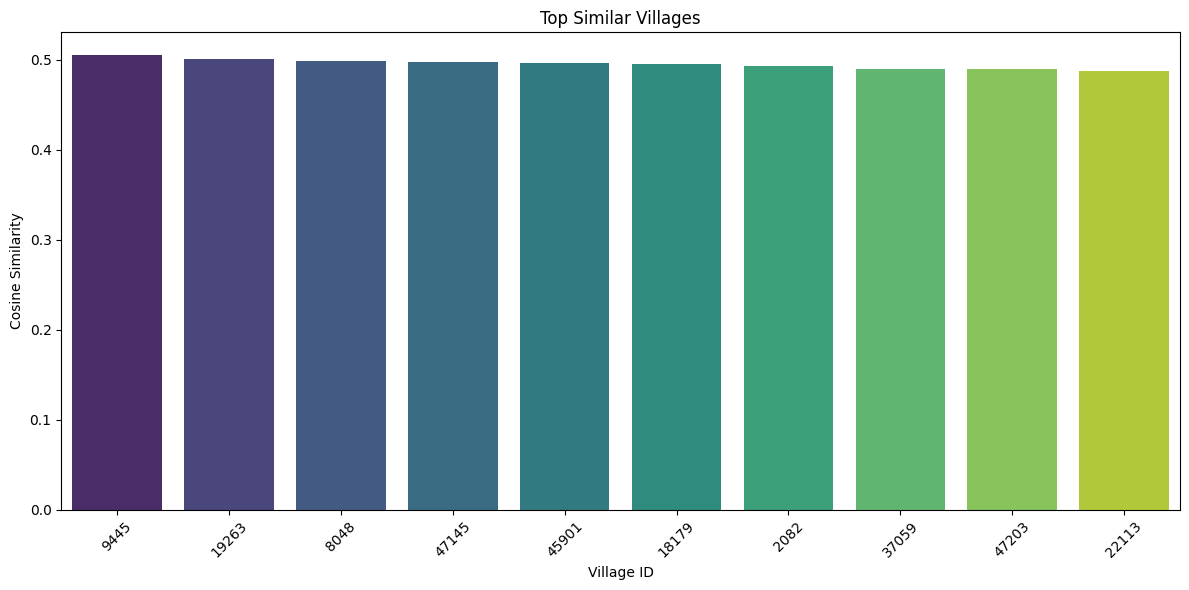

In [ ]:
# Convert df_similarities to the ranked_villages format that ndcg_at_k expects
ranked_villages_from_df = list(zip(df_similarities['cmun'], df_similarities['similarity']))

# Calculate NDCG score for the recommendations
def ndcg_at_k(ranked_list, ideal_list, k):
    def dcg(scores):
        return sum([(2**s - 1) / np.log2(i+2) for i, s in enumerate(scores)])
    
    ideal_scores = [1 if v in ideal_list else 0 for v, _ in ranked_list[:k]]
    return dcg(ideal_scores) / dcg(sorted(ideal_scores, reverse=True))

# Calculate NDCG at 10
ndcg_score = ndcg_at_k(ranked_villages_from_df, user_choices_cmun, k=10)
print(f"NDCG Score: {ndcg_score:.4f}")

# Display top similar villages
print("Top 10 Most Similar Villages:")
for village, score in ranked_villages_from_df[:10]:
    print(f"Village {village}: Similarity {score:.4f}")
    
# Optional: Add village names if available
if 'municipality' in df_pueblos.columns:
    # Create a lookup dictionary for village names
    cmun_to_name = dict(zip(df_pueblos['cmun'], df_pueblos['municipality']))
    
    print("\nTop 10 Most Similar Villages with Names:")
    for village, score in ranked_villages_from_df[:10]:
        village_name = cmun_to_name.get(village, "Unknown")
        print(f"Village {village} ({village_name}): Similarity {score:.4f}")

# Visualize top similarities with a bar chart
top_n = 10
village_ids = [str(v) for v, _ in ranked_villages_from_df[:top_n]]
similarity_scores = [score for _, score in ranked_villages_from_df[:top_n]]

plt.figure(figsize=(12, 6))
sns.barplot(x=village_ids, y=similarity_scores, hue=village_ids, palette="viridis", legend=False)
plt.title('Top Similar Villages')
plt.xlabel('Village ID')
plt.ylabel('Cosine Similarity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Compute the Graph Density
Graph density tells us how connected the graph is.
A fully connected graph has density 1, while a sparse graph has density close to 0.

If density > 0.1, your graph might be too dense.
If density < 0.01, it might be too sparse.

### Draws the network graph

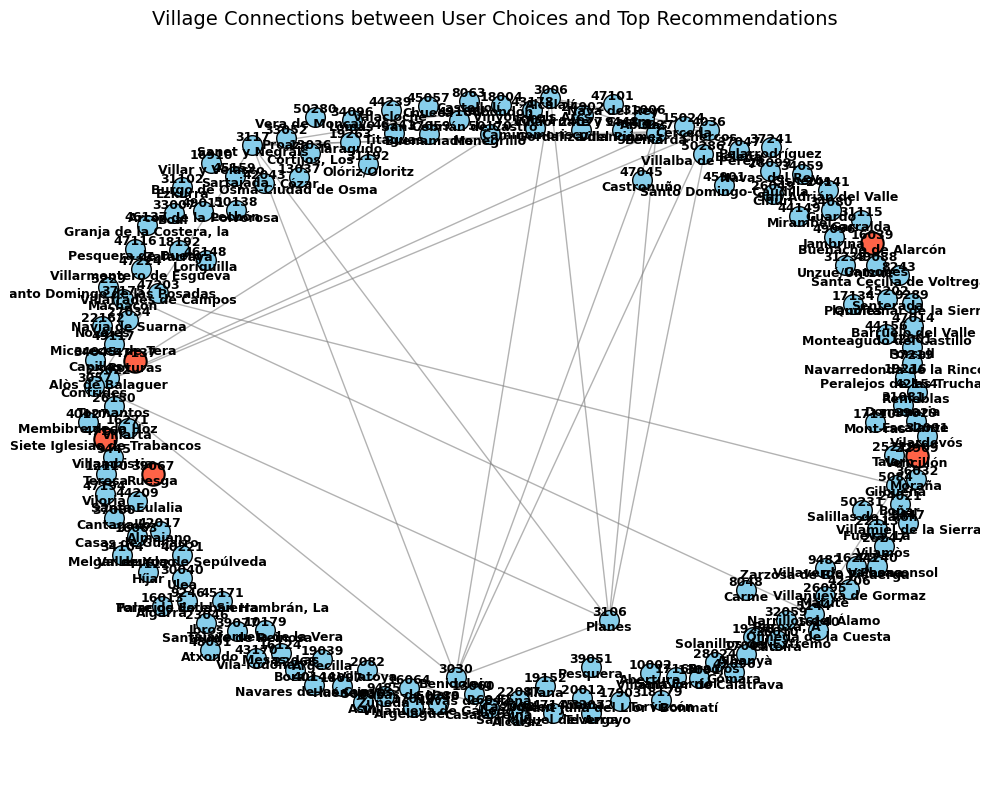

In [ ]:
def plot_small_labeled_subgraph(G, nodes_to_show, figsize=(10, 8), 
                               highlight_nodes=None, title="Village Connection Subgraph",
                               with_labels=True, node_size=200, 
                               df_pueblos=None):
    """
    Plot a small subgraph with CMUN labels visible.
    
    Parameters:
    - G: NetworkX graph
    - nodes_to_show: List of nodes to include in the visualization
    - figsize: Figure size tuple (width, height)
    - highlight_nodes: List of nodes to highlight (e.g., user selections)
    - title: Plot title
    - with_labels: Whether to show node labels
    - node_size: Size of nodes in the plot
    - df_pueblos: DataFrame with village information for name lookup
    """
    # Create subgraph of specified nodes
    H = G.subgraph(nodes_to_show)
    
    plt.figure(figsize=figsize)
    
    # Create a layout with more spacing for labels
    pos = nx.spring_layout(H, k=1.5, seed=42)  # k controls spacing
    
    # Draw edges first
    nx.draw_networkx_edges(
        H, pos,
        width=1.0,
        alpha=0.6,
        edge_color='gray'
    )
    
    # Prepare node labels
    if with_labels:
        if df_pueblos is not None:
            # Create a lookup dictionary for municipality names
            cmun_to_name = dict(zip(df_pueblos['cmun'], df_pueblos['municipality']))
            labels = {node: f"{node}\n{cmun_to_name.get(node, '')}" for node in H.nodes()}
        else:
            labels = {node: str(node) for node in H.nodes()}
    
    # Draw regular nodes
    nx.draw_networkx_nodes(
        H, pos,
        nodelist=[n for n in H.nodes() if highlight_nodes is None or n not in highlight_nodes],
        node_size=node_size,
        node_color='skyblue',
        edgecolors='black',
        linewidths=1
    )
    
    # Draw highlighted nodes if any
    if highlight_nodes:
        nx.draw_networkx_nodes(
            H, pos,
            nodelist=[n for n in H.nodes() if n in highlight_nodes],
            node_size=node_size*1.3,
            node_color='tomato',
            edgecolors='black',
            linewidths=1.5
        )
    
    # Draw labels
    if with_labels:
        nx.draw_networkx_labels(
            H, pos,
            labels=labels,
            font_size=9,
            font_weight='bold'
        )
    
    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage:
# 1. Show top recommendations and user selections
selected_nodes = user_choices_cmun
top_recommendations = [village for village, score in ranked_villages_from_df[:150]]
nodes_to_show = selected_nodes + top_recommendations

# 2. Show a small sample around a chosen node
# central_node = user_choices_cmun[0]  # First user choice
# neighbors = list(G.neighbors(central_node))
# nodes_to_show = [central_node] + neighbors[:15]  # Central node plus up to 15 neighbors

# Make the visualization
plot_small_labeled_subgraph(
    G, 
    nodes_to_show=nodes_to_show, 
    highlight_nodes=selected_nodes,
    title="Village Connections between User Choices and Top Recommendations",
    df_pueblos=df_pueblos
)